## Dependencies

In [1]:
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np

data_path = Path('./data/EchoNet-Dynamic/EchoNet-Dynamic/')
file_list_path = os.path.join(data_path,'FileList.csv')
volume_tracings_path = os.path.join(data_path,'VolumeTracings.csv')
videos_path = os.path.join(data_path,'Videos')
os.chdir('../')
%pwd

'c:\\Projects\\python\\echoframe'

In [2]:
file_list = pd.read_csv(filepath_or_buffer=file_list_path)
file_list.head()

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL


In [3]:
volume_tracings = pd.read_csv(filepath_or_buffer=volume_tracings_path)
volume_tracings.head()

,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.125000,46
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.321330,46
2,0X100009310A3BD7FC.avi,49.157378,20.407629,57.090549,18.390722,46
3,0X100009310A3BD7FC.avi,48.538173,23.581055,59.997339,20.667707,46
4,0X100009310A3BD7FC.avi,47.918968,26.754480,62.904129,22.944693,46


## Exploratory Data Analysis

### File list

In [4]:
file_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10030 entries, 0 to 10029
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FileName        10030 non-null  object 
 1   EF              10030 non-null  float64
 2   ESV             10030 non-null  float64
 3   EDV             10030 non-null  float64
 4   FrameHeight     10030 non-null  int64  
 5   FrameWidth      10030 non-null  int64  
 6   FPS             10030 non-null  int64  
 7   NumberOfFrames  10030 non-null  int64  
 8   Split           10030 non-null  object 
dtypes: float64(3), int64(4), object(2)
memory usage: 705.4+ KB


In [5]:
file_list['Split'].value_counts()

Split
TRAIN    7465
VAL      1288
TEST     1277
Name: count, dtype: int64

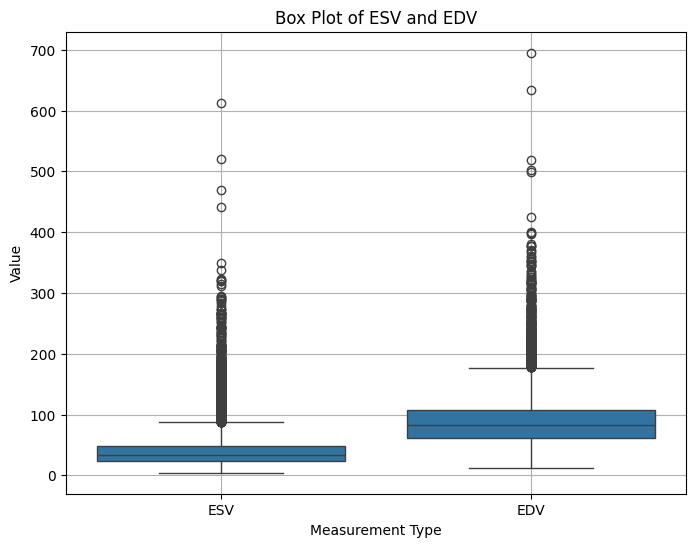

In [6]:
data_melted = file_list.melt(value_vars=["ESV", "EDV"], var_name="Measurement", value_name="Value")

plt.figure(figsize=(8, 6))
sns.boxplot(x="Measurement", y="Value", data=data_melted)
plt.xlabel("Measurement Type")
plt.ylabel("Value")
plt.title("Box Plot of ESV and EDV")
plt.grid(True)
plt.show()


In [7]:
file_list['FrameWidth'].unique()

array([ 112, 1024, 1040], dtype=int64)

In [8]:
frame_size_counts = file_list.groupby(["FrameHeight", "FrameWidth"]).size().reset_index(name="Count")
frame_size_counts

,FrameHeight,FrameWidth,Count
0,112,112,10024
1,768,1024,5
2,768,1040,1


In [9]:
outlier_frames = file_list[(file_list["FrameHeight"] != 112) | (file_list["FrameWidth"] != 112)]
outlier_frames

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
10024,0X5DD5283AC43CCDD1,62.691876,36.284389,97.256001,768,1024,50,188,TEST
10025,0X234005774F4CB5CD,51.724743,47.065329,97.493690,768,1040,50,127,TRAIN
10026,0X2DC68261CBCC04AE,62.187781,26.333478,69.642772,768,1024,50,66,TRAIN
10027,0X35291BE9AB90FB89,62.070762,49.064338,129.357561,768,1024,50,208,TRAIN
10028,0X6C435C1B417FDE8A,59.635257,57.721170,142.998978,768,1024,50,166,TRAIN
10029,0X5515B0BD077BE68A,46.019994,27.260394,50.500910,768,1024,50,126,TRAIN


### Volume Tracings

In [10]:
volume_tracings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425010 entries, 0 to 425009
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   FileName  425010 non-null  object 
 1   X1        425010 non-null  float64
 2   Y1        425010 non-null  float64
 3   X2        425010 non-null  float64
 4   Y2        425010 non-null  float64
 5   Frame     425010 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 19.5+ MB


In [11]:
vt_filenames = set(volume_tracings['FileName'].str.replace(".avi","",regex=False))
fl_filenames = set(file_list['FileName'])

missing_files = fl_filenames - vt_filenames
extra_files = vt_filenames - fl_filenames

print(f'Missing files: \n{missing_files}\n\nExtra files: \n{extra_files}')

Missing files: 
{'0X6C435C1B417FDE8A', '0X234005774F4CB5CD', '0X35291BE9AB90FB89', '0X5DD5283AC43CCDD1', '0X5515B0BD077BE68A', '0X2DC68261CBCC04AE'}

Extra files: 
{'0X4F8859C8AB4DA9CB'}


In [12]:
missing_files.intersection(outlier_frames['FileName'])

{'0X234005774F4CB5CD',
 '0X2DC68261CBCC04AE',
 '0X35291BE9AB90FB89',
 '0X5515B0BD077BE68A',
 '0X5DD5283AC43CCDD1',
 '0X6C435C1B417FDE8A'}

In [13]:
discarded_files= list(missing_files) + list(extra_files)

In [14]:
frame_extremes = volume_tracings.groupby("FileName")["Frame"].agg(ES="first", ED="last").reset_index()
frame_extremes

,FileName,ES,ED
0,0X100009310A3BD7FC.avi,46,61
1,0X1002E8FBACD08477.avi,3,18
2,0X1005D03EED19C65B.avi,24,35
3,0X10075961BC11C88E.avi,91,108
4,0X10094BA0A028EAC3.avi,137,156
...,...,...,...
10020,0XFDFBA5702E94ABF.avi,100,117
10021,0XFDFD17B7CCFE5AF.avi,66,85
10022,0XFE6E32991136338.avi,31,45
10023,0XFE83FF3D3B13C3A.avi,49,67


### Videos

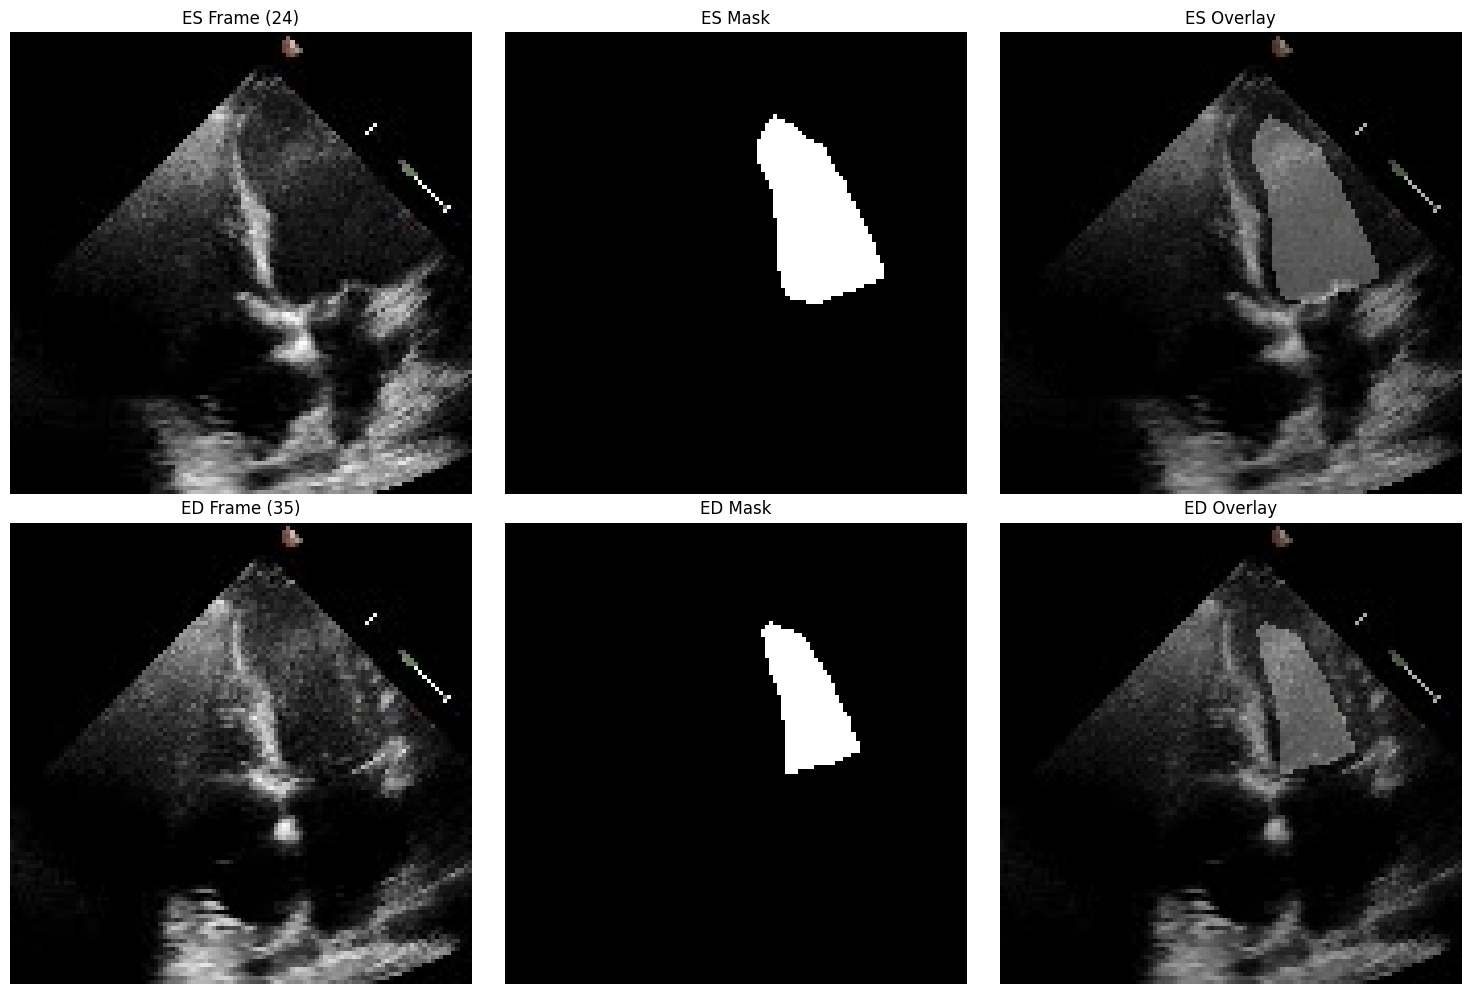

In [15]:
def build_polygons_dict(volume_csv_path):
    """
    Reads a VolumeTracings.csv in which (FileName, Frame) might appear 
    multiple times, each providing partial boundary segments.
    Returns a dict: (base_name, frame_number) -> [ [ (x1,y1), (x2,y2), ... ] ]
    """
    tracings_df = pd.read_csv(volume_csv_path)
    
    # Group by (FileName, Frame), accumulate X/Y pairs
    grouped = tracings_df.groupby(["FileName", "Frame"])
    polygons_dict = {}

    for (filename, frame), group_rows in grouped:
        coords = []
        for _, row in group_rows.iterrows():
            x1, y1 = float(row["X1"]), float(row["Y1"])
            x2, y2 = float(row["X2"]), float(row["Y2"])
            coords.append((x1, y1))
            coords.append((x2, y2))

        base_name = os.path.splitext(filename)[0]
        key = (base_name, int(frame))
        # Store all coords as one polygon boundary
        polygons_dict[key] = [coords]

    return polygons_dict

def sort_polygon_coords(coords):
    """
    Sort the list of (x,y) points by angle around the centroid, 
    so they form one continuous path for fillPoly.
    """
    centroid = np.mean(coords, axis=0)
    # angles in [-pi, pi]
    angles = [np.arctan2(y - centroid[1], x - centroid[0]) for (x, y) in coords]
    # sort by angle ascending
    sorted_idx = np.argsort(angles)
    sorted_coords = [coords[i] for i in sorted_idx]
    return sorted_coords

def create_mask(polygons_dict, video_name, frame_idx, hw_shape):
    """
    Creates a 2D mask for the given (video_name, frame_idx), 
    filling the polygon boundary in a more continuous manner.
    Also applies a small morphological close.
    """
    base_name = os.path.splitext(video_name)[0]
    key = (base_name, frame_idx)
    
    mask = np.zeros(hw_shape, dtype=np.uint8)
    if key not in polygons_dict:
        return mask  # No polygons => empty

    for polygon_coords in polygons_dict[key]:
        # 1) Sort the boundary points so they form a continuous loop
        polygon_coords_sorted = sort_polygon_coords(polygon_coords)

        # 2) Fill the polygon
        pts = np.array(polygon_coords_sorted, dtype=np.int32).reshape((-1, 1, 2))
        cv2.fillPoly(mask, [pts], 255)

    # 3) Optionally apply morphological closing to fill small holes/gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Convert to 0/1 mask if desired
    mask = (mask > 127).astype(np.uint8)
    return mask

def read_frame_resized(video_path, frame_idx, resize=(112, 112)):
    """
    Reads the given 0-based frame index from a video file,
    converts from BGR to RGB, and optionally resizes to (112,112).
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    cap.release()

    if not ret or frame is None:
        return None

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if resize is not None:
        frame = cv2.resize(frame, resize, interpolation=cv2.INTER_AREA)
    return frame


polygons_dict = build_polygons_dict(volume_csv_path=volume_tracings_path)
sample_filename = "0X1005D03EED19C65B.avi"  # must exist

# Identify frames (e.g. min=ES, max=ED)
df = pd.read_csv(volume_tracings_path)
sample_rows = df[df["FileName"] == sample_filename]
es_frame = sample_rows["Frame"].min()
ed_frame = sample_rows["Frame"].max()

video_path = os.path.join(videos_path, sample_filename)
es_frame_img = read_frame_resized(video_path, es_frame, resize=(112,112))
ed_frame_img = read_frame_resized(video_path, ed_frame, resize=(112,112))

es_mask = create_mask(polygons_dict, sample_filename, es_frame, es_frame_img.shape[:2])
ed_mask = create_mask(polygons_dict, sample_filename, ed_frame, ed_frame_img.shape[:2])

es_overlay = cv2.addWeighted(es_frame_img, 0.7,
                                cv2.cvtColor(es_mask*255, cv2.COLOR_GRAY2RGB), 0.3, 0)
ed_overlay = cv2.addWeighted(ed_frame_img, 0.7,
                                cv2.cvtColor(ed_mask*255, cv2.COLOR_GRAY2RGB), 0.3, 0)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0,0].imshow(es_frame_img)
axes[0,0].set_title(f"ES Frame ({es_frame})")
axes[0,0].axis("off")

axes[0,1].imshow(es_mask, cmap="gray")
axes[0,1].set_title("ES Mask")
axes[0,1].axis("off")

axes[0,2].imshow(es_overlay)
axes[0,2].set_title("ES Overlay")
axes[0,2].axis("off")

axes[1,0].imshow(ed_frame_img)
axes[1,0].set_title(f"ED Frame ({ed_frame})")
axes[1,0].axis("off")

axes[1,1].imshow(ed_mask, cmap="gray")
axes[1,1].set_title("ED Mask")
axes[1,1].axis("off")

axes[1,2].imshow(ed_overlay)
axes[1,2].set_title("ED Overlay")
axes[1,2].axis("off")

plt.tight_layout()
plt.show()


In [14]:
volume_tracings['FileName'].unique()[:10]

array(['0X100009310A3BD7FC.avi', '0X1002E8FBACD08477.avi',
       '0X1005D03EED19C65B.avi', '0X10075961BC11C88E.avi',
       '0X10094BA0A028EAC3.avi', '0X100CF05D141FF143.avi',
       '0X100E3B8D3280BEC5.avi', '0X100E491B3CD58DE2.avi',
       '0X100F044876B98F90.avi', '0X101026B90DAE7E95.avi'], dtype=object)